# Dogs vs Cats - Classify Images using CNN

For this project, I'm building a Convolutional Neural Network from scratch to classify dogs and college images.

I'm experimenting with the number of layers and dropout values.

This project was inspired after reading F.Chollet's Deep Learning with Python book. I have experimented, built upon the techniques suggested by F.Chollet.

This notebook is computationally heavy, so i highly suggest you make use of GPU to run this notebook.

**Note:** This project is a part of #100MLProjects, read more about it [here](https://github.com/laxmena/100MLProjects/blob/master/README.md).

**About the Dataset**

I'm using the dataset from a past Kaggle competition - [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats)

Dataset contains 25000 images of dogs and cats with equal representation in the training set, and 12500 images in the test set. 

In [7]:
# Initializing kaggle in google colab
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir .kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘.kaggle’: File exists


Copy the dataset from kaggle to Google Colab

In [8]:
# Copying the data from kaggle to google colab
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 56.6MB/s]
 99% 540M/543M [00:06<00:00, 156MB/s]
100% 543M/543M [00:06<00:00, 84.7MB/s]
 97% 263M/271M [00:04<00:00, 51.1MB/s]
100% 271M/271M [00:04<00:00, 58.3MB/s]


Unzip the dataset and clean the directory:

In [ ]:
!unzip dogs-vs-cats.zip
!mkdir train
!unzip train.zip -d train
!mkdir test
!unzip test1.zip -d test
!rm -r dogs-vs-cats.zip 
!rm -r train.zip 
!rm -r test1.zip 

## Starting Up:

Ideas:
- For this project, I'm building a Deep Learning model from scratch using Convolutional Neural networks.
- I'm experimenting with the number of layers and number of hidden units.


In [54]:
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [11]:
IMAGE_SHAPE = (150, 150, 3)
TRAIN_PATH = os.path.join('train', 'train')
TEST_PATH = os.path.join('test', 'test1')

In the previous notebook, I've directly fetched the image data from the directory. 

For this notebook, I'll store the filenames and its class in a dataframe, and use the dataframe as input to the ImageDataGenerator.

I feel dataframe method is more organized, and gives us more flexibility than directly accessing from the directory.

In [12]:
files = os.listdir(TRAIN_PATH)
categories = []

for file in files:
    category = file.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': files, 
    'category': categories
})

print(df.size)
df.head()

50000


,filename,category
0,cat.10655.jpg,0
1,dog.5465.jpg,1
2,cat.11622.jpg,0
3,dog.5218.jpg,1
4,dog.2268.jpg,1


Note: Kaggle Dataset description mentions that 'Dog' should be classified as 1, and cat as 0.

**Data Distribution Visualization:**

Dataset description mentions that the data is equally distributed between the classes, but still verifying it once more to be sure.

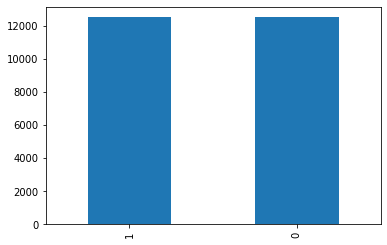

In [13]:
df['category'].value_counts().plot(kind='bar')

## Building a Model

**Brief Description:**
1. Conv2D - 2D Convolutional layer. <br/>
We specify the output channel depth and the window size, this window moves over every possible location of the input feature map, does some tensor transformation and combines the result to form a output feature map.  
2. MaxPooling2D - Max Pooling Layer. <br/>
This layer aggressively downsamples the feature map. Maxpooling is done usually by using 2x2 window and a stride of 2. Window slides over the feature map, finds the max value in that window, and creates a new output feature map with that max value instead of the entire 2x2 window.
3. Dropout Layer <br/>
Dropout layer is used to prevent overfitting. Dropout rate is provided as the argument for the function. If the dropout rate is 0.2, then 20% of the output features are randomly selected and the values are made 0. This prevents the model from learning unnecessary irrelevant patterns in the data.

This is my Architecture of the convolutional neural network

Sequential Network:

1. **Conv2D layer 1**: window size = 3x3; output layer depth = 32; 
2. **BatchNormalization** layer
3. **MaxPooling2D 1**: window size = 2x2;
4. **Dropout layer**: dropout rate = 0.20;

1. **Conv2D layer 2**: window size = 3x3; output layer depth = 64; 
1. **Conv2D layer 3**: window size = 3x3; output layer depth = 64; 
2. **BatchNormalization** layer
3. **MaxPooling2D 2**: window size = 2x2;
4. **Dropout layer**: dropout rate = 0.25;
1. **Conv2D layer 4**: window size = 3x3; output layer depth = 128; 
1. **Conv2D layer 5**: window size = 3x3; output layer depth = 128; 
1. **Conv2D layer 6**: window size = 3x3; output layer depth = 128; 
2. **BatchNormalization** layer
3. **MaxPooling2D 3**: window size = 2x2;
4. **Dropout layer**: dropout rate = 0.30;
1. **Conv2D layer 7**: window size = 3x3; output layer depth = 256; 
2. **BatchNormalization** layer
3. **MaxPooling2D 4**: window size = 2x2;
4. **Dropout layer**: dropout rate = 0.40;
20. **Flatten Layer**
21. **Dense Layer 1**: Hidden units=512; 
22. **Dense Layer 2**: Hidden units=2; activation=softmax;


In [14]:
def build_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.20))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.30))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 64)        2

I'm Creating CallBacks for the following purposes:
- Reduce Learning rate when accuracy doesnt improve much
- Create checkpoints and save a copy of the trained model after improvement in loss value reduction.
- If there are no significant improvement for 10 epochs, stop the training 

In [16]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

Data Preparation

Since I'm going to provide class_mode as categorical, its better to have the target labels as a string.

So I'm converting the binary values back to string.

(Note: This could be also be done in the initial step by directly assigning string values as target labels)

In [17]:
df['category'] = df['category'].replace({1:'dog', 0:'cat'})

Splitting the dataset into Training and Validation dataset

In [21]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=28)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

Visualizing how the data is distributed after splitting it into training and test dataset.

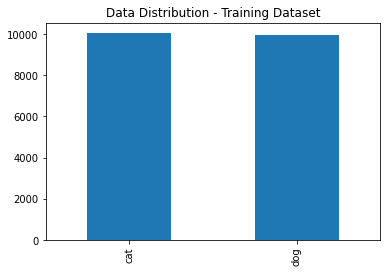

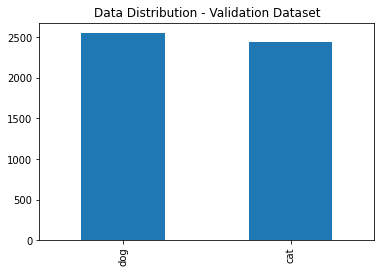

In [22]:
train_df['category'].value_counts().plot.bar()
plt.title('Data Distribution - Training Dataset')
plt.show()
valid_df['category'].value_counts().plot.bar()
plt.title('Data Distribution - Validation Dataset')
plt.show()

In [25]:
train_count = len(train_df)
valid_count = len(valid_df)
batch_size = 25

Initializing ImageDataGenerator's, which can then be provided to the model for training. 

This generator helps us feed the training data to the model as batches, and also allows us to augment the images.

Image Augmentation is a process of modifying an image in such a way that it looks real, but still different from the original image. We can rotate the image, zoom in or our, flip the image, etc.

if we provide the configurations, ImageDataGenerator automatically takes care of augmentation. So, the model will see a new image everytime. 

In [26]:
train_datagen = ImageDataGenerator(rotation_range=20, 
                               rescale=1./255, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SHAPE[:2],
    class_mode = 'categorical',
    batch_size = batch_size
)

valid_gen = train_datagen.flow_from_dataframe(
    valid_df,
    directory = TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SHAPE[:2],
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [27]:
epoch = 30
history = model.fit(
    train_gen,
    epochs=epoch,
    steps_per_epoch = train_count // batch_size,
    validation_data = valid_gen,
    validation_steps = valid_count // batch_size,
    callbacks = callbacks
)

Epoch 1/30
800/800 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.5692
Epoch 00001: loss improved from inf to 0.77654, saving model to model.h5
800/800 [==============================] - 188s 235ms/step - loss: 0.7765 - accuracy: 0.5692 - val_loss: 0.6847 - val_accuracy: 0.5830
Epoch 2/30
800/800 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.6808
Epoch 00002: loss improved from 0.77654 to 0.60248, saving model to model.h5
800/800 [==============================] - 182s 228ms/step - loss: 0.6025 - accuracy: 0.6808 - val_loss: 0.5989 - val_accuracy: 0.6522
Epoch 3/30
800/800 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.7397
Epoch 00003: loss improved from 0.60248 to 0.53253, saving model to model.h5
800/800 [==============================] - 180s 225ms/step - loss: 0.5325 - accuracy: 0.7397 - val_loss: 0.5863 - val_accuracy: 0.6930
Epoch 4/30
800/800 [==============================] - ETA: 0s - loss: 0.4784 - a

From the logs, we could see that our model has reached a maximum validation accuracy of about ~94%, which is really good. But there is still room for improvement.

In [28]:
model.save_weights("dog_vs_cat_3.h5")

## Visualizing Accuracy and Loss

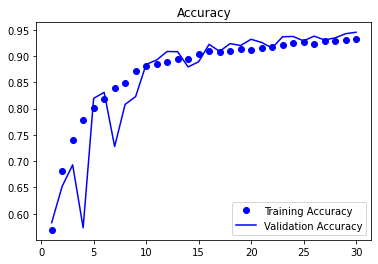

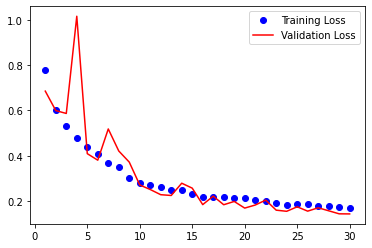

In [32]:
epoch_count = range(1, len(history.history['accuracy'])+1)

plt.plot(epoch_count, history.history['accuracy'], 'bo', label='Training Accuracy')
plt.plot(epoch_count, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure()

plt.plot(epoch_count, history.history['loss'], 'bo', label='Training Loss')
plt.plot(epoch_count, history.history['val_loss'], 'r', label='Validation Loss')
plt.legend()
plt.show()

From the plot above, we could see that the model didnt overfit, and kept improving. We could still go on for few more epochs to improve the performance, but I stopped it here at 30 epochs.

## Test Input

In this section, the model built is used to predict the test data.

In [35]:
test_files = os.listdir(TEST_PATH)

test_df = pd.DataFrame({
    'filename': test_files
})

test_samples = test_df.shape[0]

In [43]:
test_gen = ImageDataGenerator(rescale=(1./255))
test_generator = test_gen.flow_from_dataframe(
    test_df,
    shuffle = False,
    directory = TEST_PATH,
    x_col = 'filename',
    y_col = None,
    target_size=IMAGE_SHAPE[:2],
    class_mode = None,
    batch_size = batch_size
)

Found 12500 validated image filenames.


In [48]:
from math import ceil
pred = model.predict(test_generator, steps=ceil(test_samples/batch_size))
test_df['category'] = np.argmax(pred, axis=-1)

In [49]:
label_map = dict((v,k) for k,v in train_gen.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [50]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

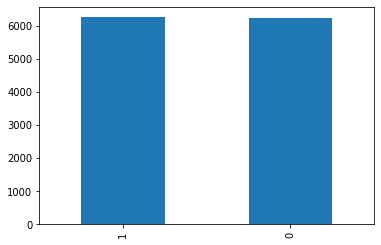

In [51]:
test_df['category'].value_counts().plot.bar()

### Visualizing predicitons 

Here we select few images from the test dataset, and output what our model has predicted the image is.

In the plot below, check the value in the paranthesis next to the name of the file under each image.

If the value is 0, the model predicted that this is a cat.
If its 1, then the model predicted that the animal in the image is a dog.

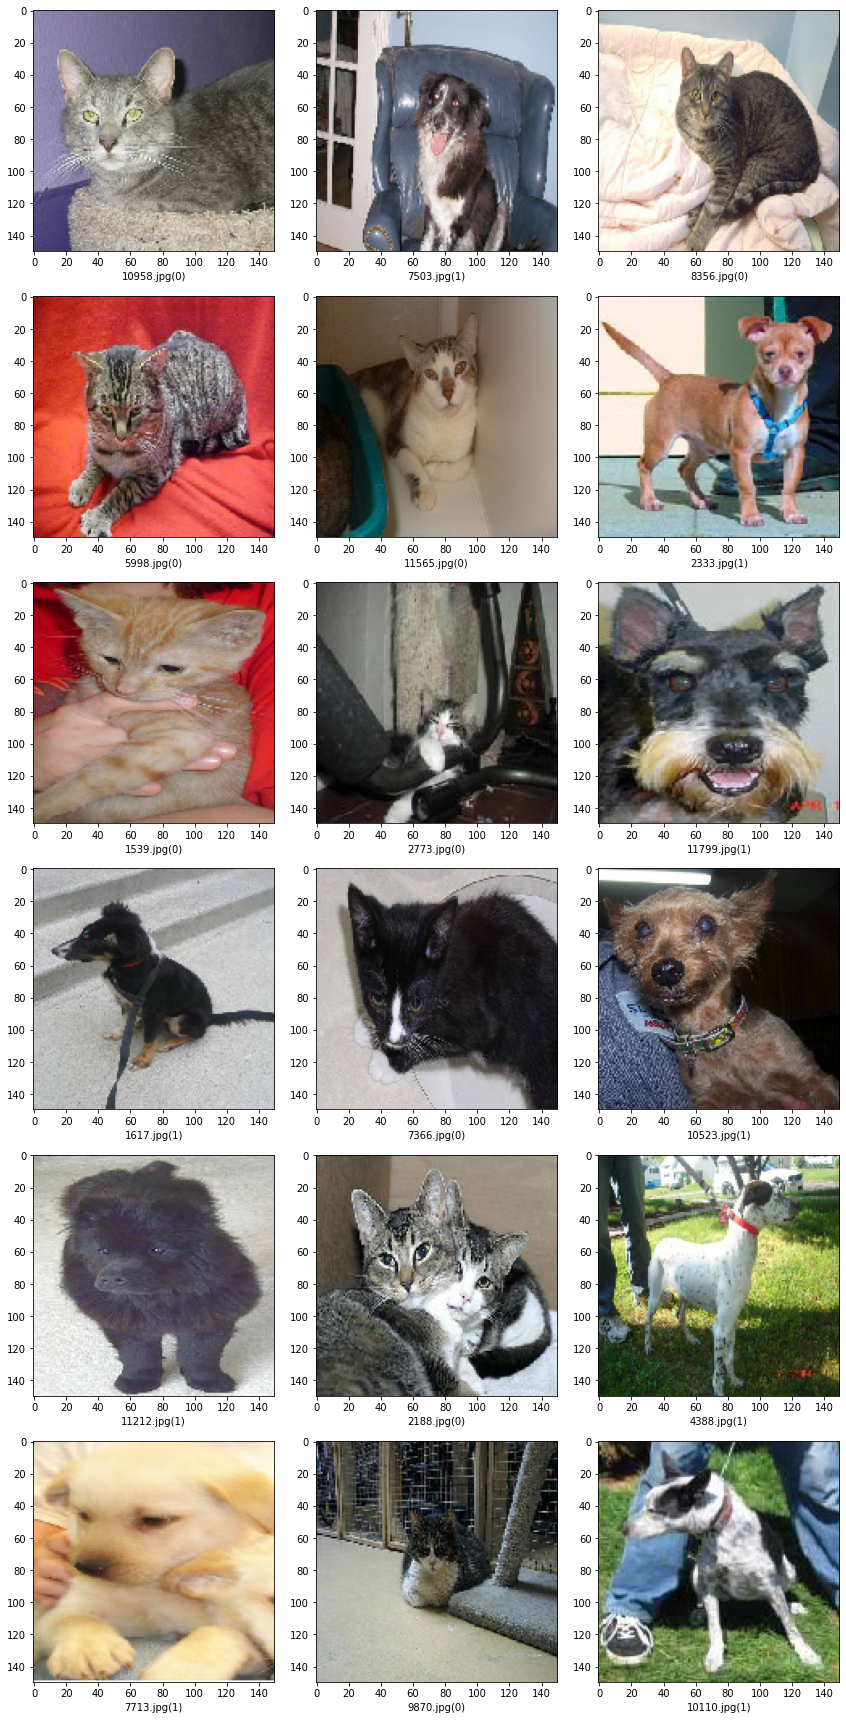

In [55]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(os.path.join(TEST_PATH,filename), target_size=IMAGE_SHAPE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

From the sample here, we can conclude that our model has perfomed decently in predicting dogs and cats.

In [56]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

Do check out my other #100MLProjects here at [Github - Laxmena - 100MLProjects](https://github.com/laxmena/100MLProjects)
<br/><br/>
**Reach out to me through:**

GitHub: https://github.com/laxmena

Medium: https://medium.com/@laxmena

LinkedIn: https://www.linkedin.com/in/lakshmanan-meiyappan/

Kaggle: https://www.kaggle.com/laxmena